In [7]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, kstest, anderson, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("库导入成功！")

库导入成功！


In [2]:
# 加载数据
def load_data():
    """加载男性胎儿NIPT数据"""
    try:
        df = pd.read_csv('CUMCM2025Problems/C题/boy.csv', encoding='gbk')
        print(f"数据加载成功！数据形状: {df.shape}")
        return df
    except Exception as e:
        print(f"数据加载失败: {e}")
        return None

# 加载数据
df_raw = load_data()
if df_raw is not None:
    print(f"数据维度: {df_raw.shape}")
    print(f"列名: {df_raw.columns.tolist()[:10]}...")  # 显示前10个列名

数据加载成功！数据形状: (1082, 31)
数据维度: (1082, 31)
列名: ['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周']...


In [3]:
# 数据预处理和基本信息
def preprocess_and_explore(df):
    """数据预处理和基本探索"""
    
    # 处理多次检测：对同一孕妇同一次采血的多次检测取平均值
    df_agg = df.groupby(['孕妇代码', '检测抽血次数']).agg({
        '年龄': 'first',
        '身高': 'first', 
        '体重': 'mean',
        '检测孕周': 'first',
        '孕妇BMI': 'mean',
        'Y染色体浓度': 'mean',
        'Y染色体的Z值': 'mean',
        '13号染色体的Z值': 'mean',
        '18号染色体的Z值': 'mean',
        '21号染色体的Z值': 'mean'
    }).reset_index()
    
    # 筛选有效数据：Y染色体浓度非空且大于0
    df_valid = df_agg[(df_agg['Y染色体浓度'] > 0) & (df_agg['Y染色体浓度'].notna())]
    
    print(f"原始数据行数: {len(df)}")
    print(f"聚合后数据行数: {len(df_agg)}")
    print(f"有效Y染色体浓度数据行数: {len(df_valid)}")
    
    return df_valid

# 数据预处理
df_clean = preprocess_and_explore(df_raw)

原始数据行数: 1082
聚合后数据行数: 1021
有效Y染色体浓度数据行数: 1021


In [4]:
# 基本描述性统计
print("="*60)
print("关键变量的描述性统计")
print("="*60)

key_vars = ['年龄', '身高', '体重', '孕妇BMI', 'Y染色体浓度', 'Y染色体的Z值']
desc_stats = df_clean[key_vars].describe()
print(desc_stats)

print("\n" + "="*60)
print("缺失值统计")
print("="*60)
missing_stats = df_clean[key_vars].isnull().sum()
print(missing_stats)

关键变量的描述性统计
                年龄           身高           体重        孕妇BMI       Y染色体浓度  \
count  1021.000000  1021.000000  1021.000000  1021.000000  1021.000000   
mean     28.903036   161.048482    83.840343    32.271221     0.078037   
std       3.574337     5.183812     9.978012     2.989324     0.033378   
min      21.000000   144.000000    53.000000    20.703125     0.010004   
25%      27.000000   158.000000    77.000000    30.176899     0.052238   
50%      29.000000   161.000000    82.500000    31.793397     0.076039   
75%      31.000000   165.000000    89.000000    33.863298     0.099180   
max      43.000000   175.000000   140.000000    46.875000     0.234218   

           Y染色体的Z值  
count  1021.000000  
mean      0.138259  
std       1.267789  
min      -4.005487  
25%      -0.666276  
50%       0.009795  
75%       0.841216  
max       6.741264  

缺失值统计
年龄         0
身高         0
体重         0
孕妇BMI      0
Y染色体浓度     0
Y染色体的Z值    0
dtype: int64


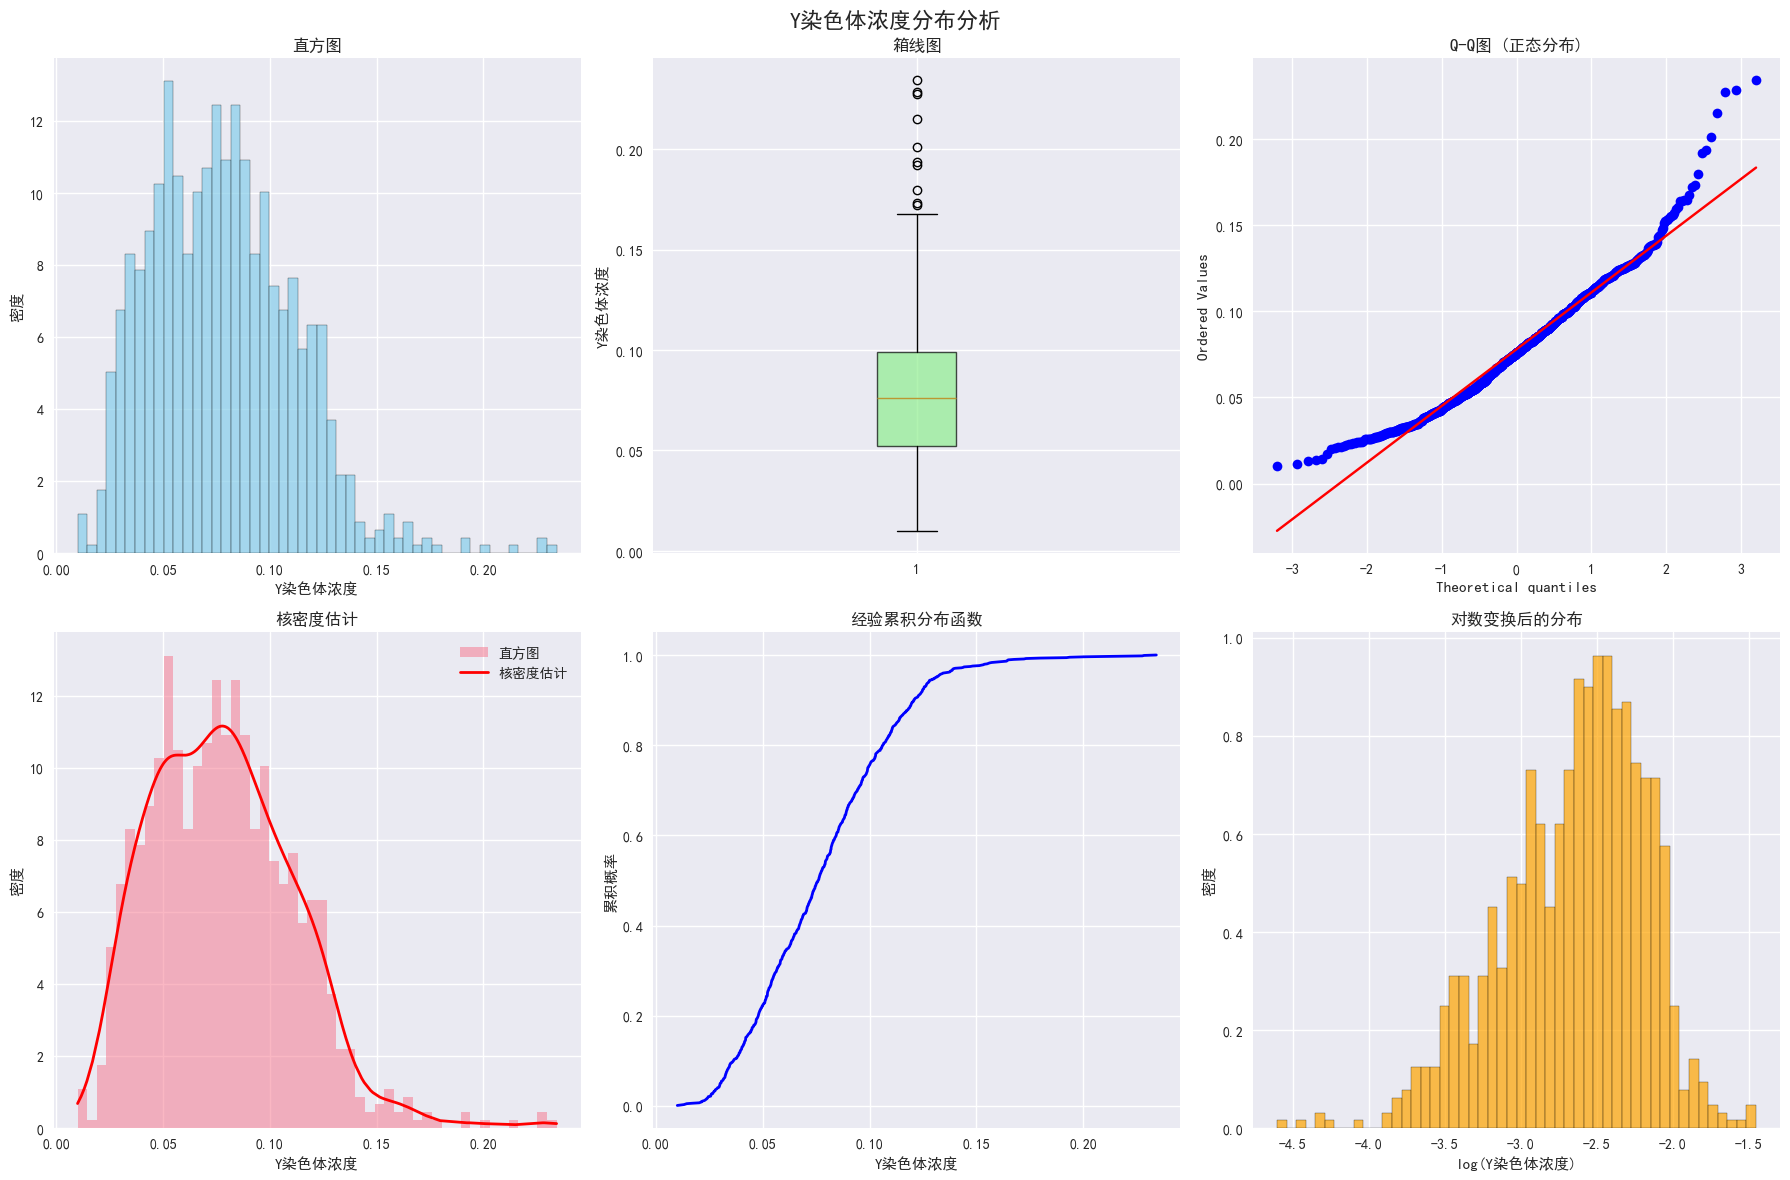

样本数量: 1021
均值: 0.078037
中位数: 0.076039
标准差: 0.033378
偏度: 0.6930
峰度: 1.0641
最小值: 0.010004
最大值: 0.234218


In [9]:
# Y染色体浓度分布的可视化分析
def analyze_y_chromosome_distribution(df):
    """分析Y染色体浓度的分布"""
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    y_concentration = df['Y染色体浓度'].dropna()
    
    # 创建子图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Y染色体浓度分布分析', fontsize=16, fontweight='bold')
    
    # 1. 直方图
    axes[0,0].hist(y_concentration, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('直方图')
    axes[0,0].set_xlabel('Y染色体浓度')
    axes[0,0].set_ylabel('密度')
    
    # 2. 箱线图
    axes[0,1].boxplot(y_concentration, vert=True, patch_artist=True, 
                     boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[0,1].set_title('箱线图')
    axes[0,1].set_ylabel('Y染色体浓度')
    
    # 3. Q-Q图 (正态分布)
    stats.probplot(y_concentration, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q图 (正态分布)')
    axes[0,2].grid(True)
    
    # 4. 核密度估计
    axes[1,0].hist(y_concentration, bins=50, density=True, alpha=0.5, label='直方图')
    axes[1,0].plot(sorted(y_concentration), stats.gaussian_kde(y_concentration)(sorted(y_concentration)), 
                   'r-', linewidth=2, label='核密度估计')
    axes[1,0].set_title('核密度估计')
    axes[1,0].set_xlabel('Y染色体浓度')
    axes[1,0].set_ylabel('密度')
    axes[1,0].legend()
    
    # 5. 累积分布函数
    sorted_data = np.sort(y_concentration)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    axes[1,1].plot(sorted_data, cumulative, 'b-', linewidth=2)
    axes[1,1].set_title('经验累积分布函数')
    axes[1,1].set_xlabel('Y染色体浓度')
    axes[1,1].set_ylabel('累积概率')
    axes[1,1].grid(True)
    
    # 6. 对数变换后的分布
    log_y = np.log(y_concentration + 1e-10)  # 加小值避免log(0)
    axes[1,2].hist(log_y, bins=50, density=True, alpha=0.7, color='orange', edgecolor='black')
    axes[1,2].set_title('对数变换后的分布')
    axes[1,2].set_xlabel('log(Y染色体浓度)')
    axes[1,2].set_ylabel('密度')
    
    plt.tight_layout()
    plt.show()
    
    # 基本统计信息
    print(f"样本数量: {len(y_concentration)}")
    print(f"均值: {y_concentration.mean():.6f}")
    print(f"中位数: {y_concentration.median():.6f}")
    print(f"标准差: {y_concentration.std():.6f}")
    print(f"偏度: {y_concentration.skew():.4f}")
    print(f"峰度: {y_concentration.kurtosis():.4f}")
    print(f"最小值: {y_concentration.min():.6f}")
    print(f"最大值: {y_concentration.max():.6f}")

# 执行分析
analyze_y_chromosome_distribution(df_clean)

In [10]:
# 分布检验函数
def distribution_tests(data, variable_name="变量"):
    """对数据进行各种分布检验"""
    
    print(f"\n{'='*60}")
    print(f"{variable_name} 的分布检验结果")
    print(f"{'='*60}")
    
    # 移除缺失值
    clean_data = data.dropna()
    n = len(clean_data)
    
    if n < 3:
        print("样本量太小，无法进行分布检验")
        return
    
    # 1. Shapiro-Wilk正态性检验 (样本量 < 5000)
    if n <= 5000:
        try:
            shapiro_stat, shapiro_p = shapiro(clean_data)
            print(f"1. Shapiro-Wilk 正态性检验:")
            print(f"   统计量: {shapiro_stat:.6f}")
            print(f"   p值: {shapiro_p:.6f}")
            print(f"   结论: {'接受正态分布假设' if shapiro_p > 0.05 else '拒绝正态分布假设'}")
        except Exception as e:
            print(f"1. Shapiro-Wilk 检验失败: {e}")
    else:
        print("1. Shapiro-Wilk 检验: 样本量太大，跳过")
    
    # 2. Kolmogorov-Smirnov检验 (正态分布)
    try:
        # 标准化数据
        standardized = (clean_data - clean_data.mean()) / clean_data.std()
        ks_stat, ks_p = kstest(standardized, 'norm')
        print(f"\n2. Kolmogorov-Smirnov 正态性检验:")
        print(f"   统计量: {ks_stat:.6f}")
        print(f"   p值: {ks_p:.6f}")
        print(f"   结论: {'接受正态分布假设' if ks_p > 0.05 else '拒绝正态分布假设'}")
    except Exception as e:
        print(f"\n2. Kolmogorov-Smirnov 检验失败: {e}")
    
    # 3. Anderson-Darling检验
    try:
        ad_stat, ad_critical, ad_significance = anderson(clean_data, dist='norm')
        print(f"\n3. Anderson-Darling 正态性检验:")
        print(f"   统计量: {ad_stat:.6f}")
        print(f"   临界值 (5%): {ad_critical[2]:.6f}")
        print(f"   结论: {'接受正态分布假设' if ad_stat < ad_critical[2] else '拒绝正态分布假设'}")
    except Exception as e:
        print(f"\n3. Anderson-Darling 检验失败: {e}")
    
    # 4. Jarque-Bera检验
    try:
        jb_stat, jb_p = jarque_bera(clean_data)
        print(f"\n4. Jarque-Bera 正态性检验:")
        print(f"   统计量: {jb_stat:.6f}")
        print(f"   p值: {jb_p:.6f}")
        print(f"   结论: {'接受正态分布假设' if jb_p > 0.05 else '拒绝正态分布假设'}")
    except Exception as e:
        print(f"\n4. Jarque-Bera 检验失败: {e}")
    
    # 5. 拟合其他分布
    print(f"\n5. 拟合常见分布:")
    
    distributions = [
        ('正态分布', stats.norm),
        ('对数正态分布', stats.lognorm),
        ('指数分布', stats.expon),
        ('Gamma分布', stats.gamma),
        ('Weibull分布', stats.weibull_min),
        ('Beta分布', stats.beta)
    ]
    
    best_dist = None
    best_p = 0
    best_name = ""
    
    for name, distribution in distributions:
        try:
            # 只对正值数据测试对数正态分布
            if name == '对数正态分布' and (clean_data <= 0).any():
                continue
            
            # Beta分布需要数据在(0,1)范围内
            if name == 'Beta分布':
                if clean_data.min() < 0 or clean_data.max() > 1:
                    continue
            
            # 拟合参数
            params = distribution.fit(clean_data)
            
            # K-S检验
            ks_stat, ks_p = kstest(clean_data, lambda x: distribution.cdf(x, *params))
            
            print(f"   {name}: K-S统计量={ks_stat:.4f}, p值={ks_p:.4f}")
            
            if ks_p > best_p:
                best_p = ks_p
                best_dist = distribution
                best_name = name
                
        except Exception as e:
            print(f"   {name}: 拟合失败 - {e}")
    
    print(f"\n最佳拟合分布: {best_name} (p值: {best_p:.4f})")
    
    return best_name, best_p

# 对Y染色体浓度进行分布检验
distribution_tests(df_clean['Y染色体浓度'], "Y染色体浓度")


Y染色体浓度 的分布检验结果
1. Shapiro-Wilk 正态性检验:
   统计量: 0.969124
   p值: 0.000000
   结论: 拒绝正态分布假设

2. Kolmogorov-Smirnov 正态性检验:
   统计量: 0.045254
   p值: 0.029605
   结论: 拒绝正态分布假设

3. Anderson-Darling 正态性检验:
   统计量: 3.966624
   临界值 (5%): 0.784000
   结论: 拒绝正态分布假设

4. Jarque-Bera 正态性检验:
   统计量: 128.647251
   p值: 0.000000
   结论: 拒绝正态分布假设

5. 拟合常见分布:
   正态分布: K-S统计量=0.0454, p值=0.0291
   对数正态分布: K-S统计量=0.0312, p值=0.2664
   指数分布: K-S统计量=0.2345, p值=0.0000
   Gamma分布: K-S统计量=0.0320, p值=0.2404
   Weibull分布: K-S统计量=0.0257, p值=0.5008
   Beta分布: K-S统计量=0.0320, p值=0.2404

最佳拟合分布: Weibull分布 (p值: 0.5008)


('Weibull分布', np.float64(0.5007876112850373))

In [ ]:
# 其他关键变量的分布分析
def analyze_multiple_distributions(df):
    """分析多个变量的分布"""
    
    key_vars = ['年龄', '身高', '体重', '孕妇BMI', 'Y染色体的Z值']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('关键变量分布分析', fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for i, var in enumerate(key_vars):
        if i < len(axes):
            data = df[var].dropna()
            
            # 直方图和核密度估计
            axes[i].hist(data, bins=30, density=True, alpha=0.7, color=f'C{i}')
            
            # 核密度估计
            try:
                kde_x = np.linspace(data.min(), data.max(), 100)
                kde_y = stats.gaussian_kde(data)(kde_x)
                axes[i].plot(kde_x, kde_y, 'r-', linewidth=2, label='KDE')
            except:
                pass
            
            axes[i].set_title(f'{var}的分布')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('密度')
            axes[i].grid(True, alpha=0.3)
    
    # 移除多余的子图
    if len(key_vars) < len(axes):
        for j in range(len(key_vars), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # 对每个变量进行分布检验
    for var in key_vars:
        distribution_tests(df[var], var)

# 执行多变量分布分析
analyze_multiple_distributions(df_clean)

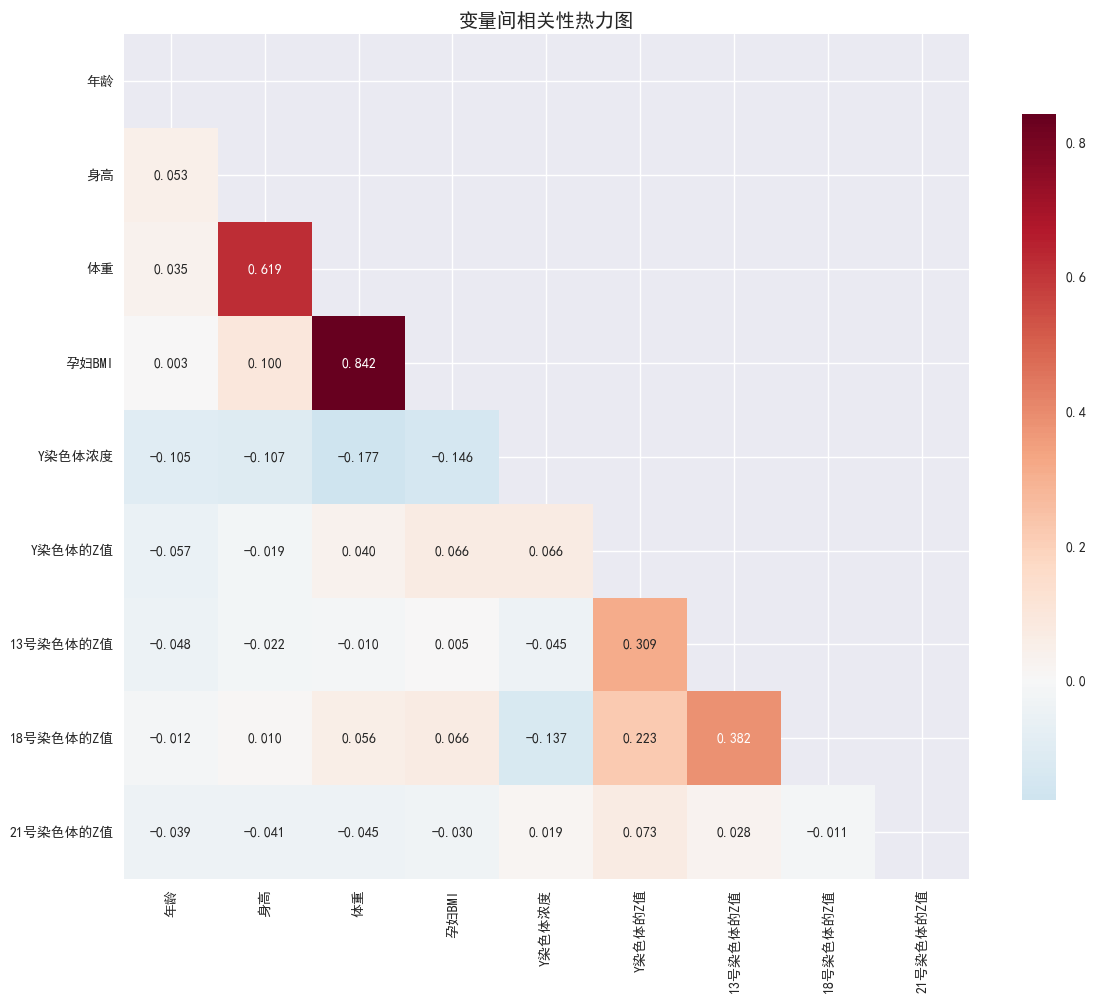


与Y染色体浓度的相关性排序:
体重: 0.1771
孕妇BMI: 0.1456
18号染色体的Z值: 0.1366
身高: 0.1074
年龄: 0.1046
Y染色体的Z值: 0.0659
13号染色体的Z值: 0.0447
21号染色体的Z值: 0.0191


In [12]:
# 相关性分析
def correlation_analysis(df):
    """相关性分析和可视化"""
    
    # 选择数值型变量
    numeric_vars = ['年龄', '身高', '体重', '孕妇BMI', 'Y染色体浓度', 'Y染色体的Z值', 
                   '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值']
    
    # 计算相关系数矩阵
    correlation_matrix = df[numeric_vars].corr()
    
    # 创建热力图
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 只显示下三角
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={"shrink": .8})
    
    plt.title('变量间相关性热力图', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 找出与Y染色体浓度相关性最强的变量
    y_corr = correlation_matrix['Y染色体浓度'].abs().sort_values(ascending=False)
    print("\n与Y染色体浓度的相关性排序:")
    print("="*40)
    for var, corr in y_corr.items():
        if var != 'Y染色体浓度':
            print(f"{var}: {corr:.4f}")
    
    return correlation_matrix

# 执行相关性分析
corr_matrix = correlation_analysis(df_clean)

<Figure size 1500x1200 with 0 Axes>

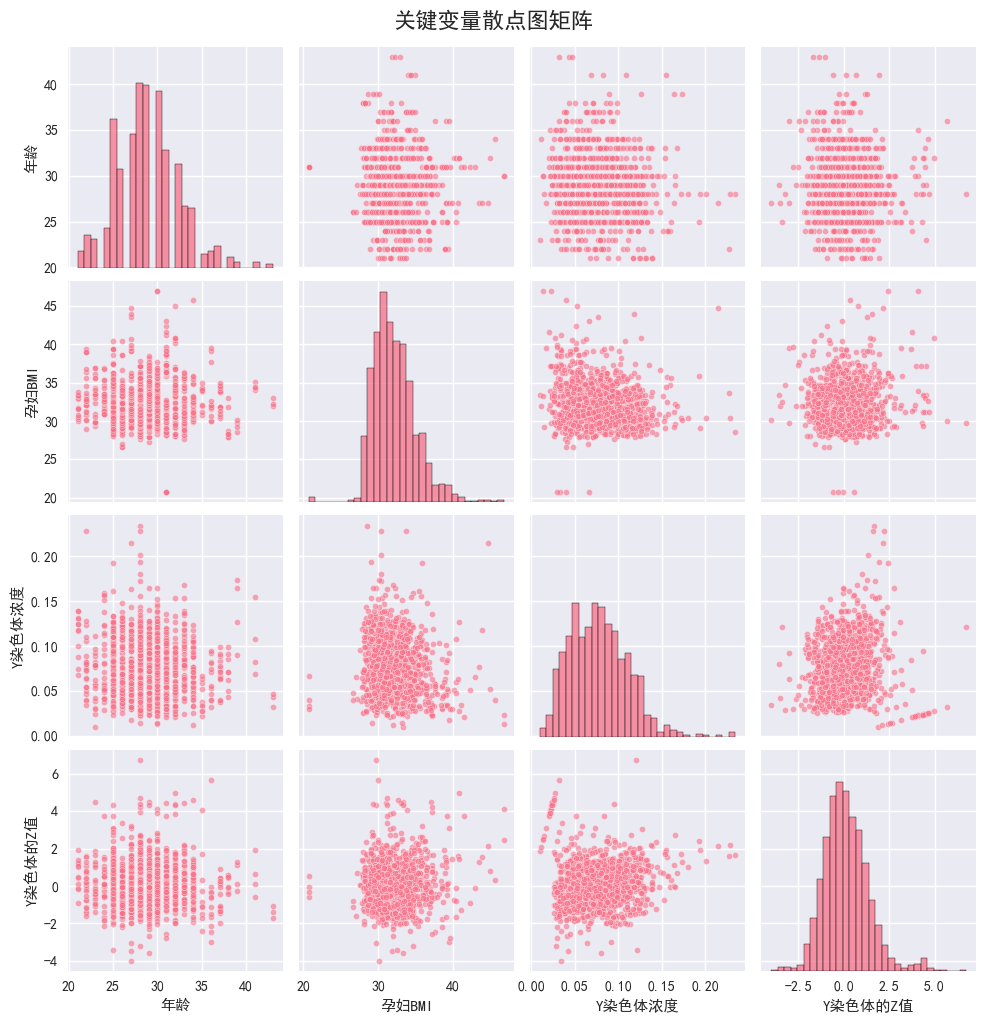

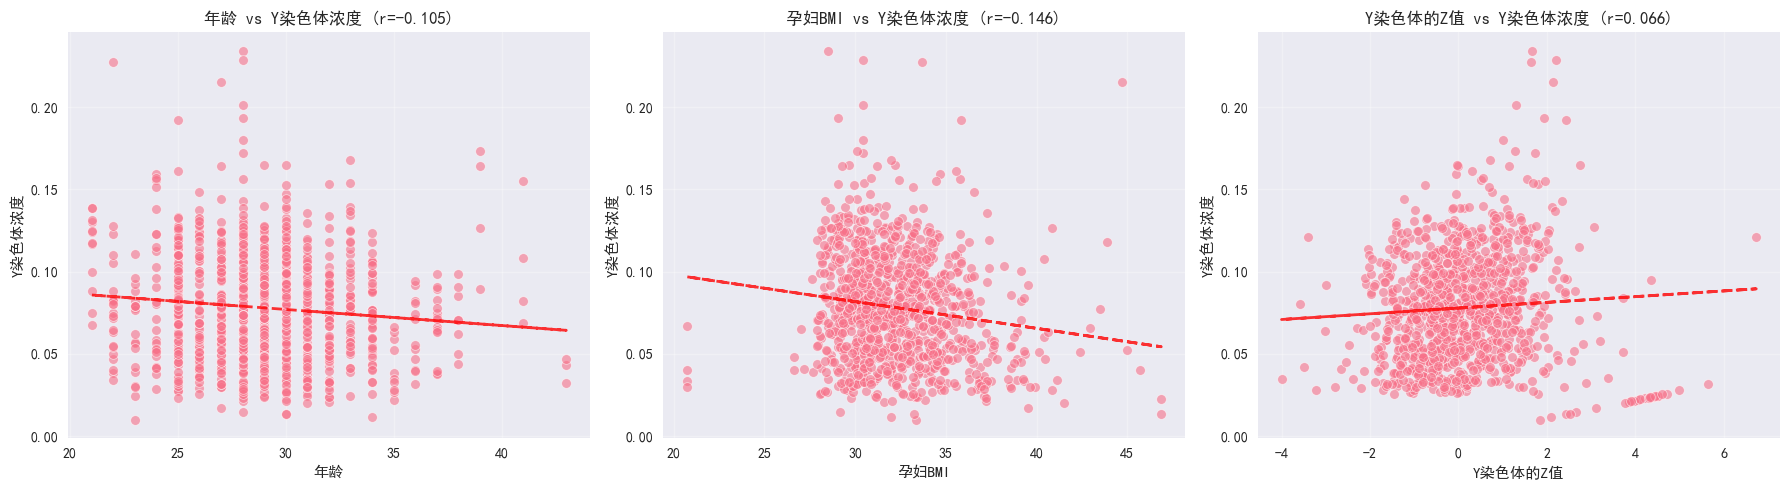

In [13]:
# 散点图矩阵分析
def scatter_matrix_analysis(df):
    """创建散点图矩阵来观察变量间关系"""
    
    # 选择关键变量
    key_vars = ['年龄', '孕妇BMI', 'Y染色体浓度', 'Y染色体的Z值']
    
    # 创建散点图矩阵
    fig = plt.figure(figsize=(15, 12))
    
    # 使用seaborn的pairplot
    g = sns.pairplot(df[key_vars], 
                     diag_kind='hist',
                     plot_kws={'alpha': 0.6, 's': 20},
                     diag_kws={'bins': 30})
    
    # 设置标题
    g.fig.suptitle('关键变量散点图矩阵', fontsize=16, fontweight='bold', y=1.02)
    
    plt.show()
    
    # 重点关注与Y染色体浓度的关系
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    other_vars = ['年龄', '孕妇BMI', 'Y染色体的Z值']
    
    for i, var in enumerate(other_vars):
        sns.scatterplot(data=df, x=var, y='Y染色体浓度', alpha=0.6, ax=axes[i])
        
        # 添加趋势线
        z = np.polyfit(df[var].dropna(), df.loc[df[var].notna(), 'Y染色体浓度'], 1)
        p = np.poly1d(z)
        axes[i].plot(df[var], p(df[var]), "r--", alpha=0.8, linewidth=2)
        
        # 计算相关系数
        corr = df[var].corr(df['Y染色体浓度'])
        axes[i].set_title(f'{var} vs Y染色体浓度 (r={corr:.3f})')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 执行散点图分析
scatter_matrix_analysis(df_clean)

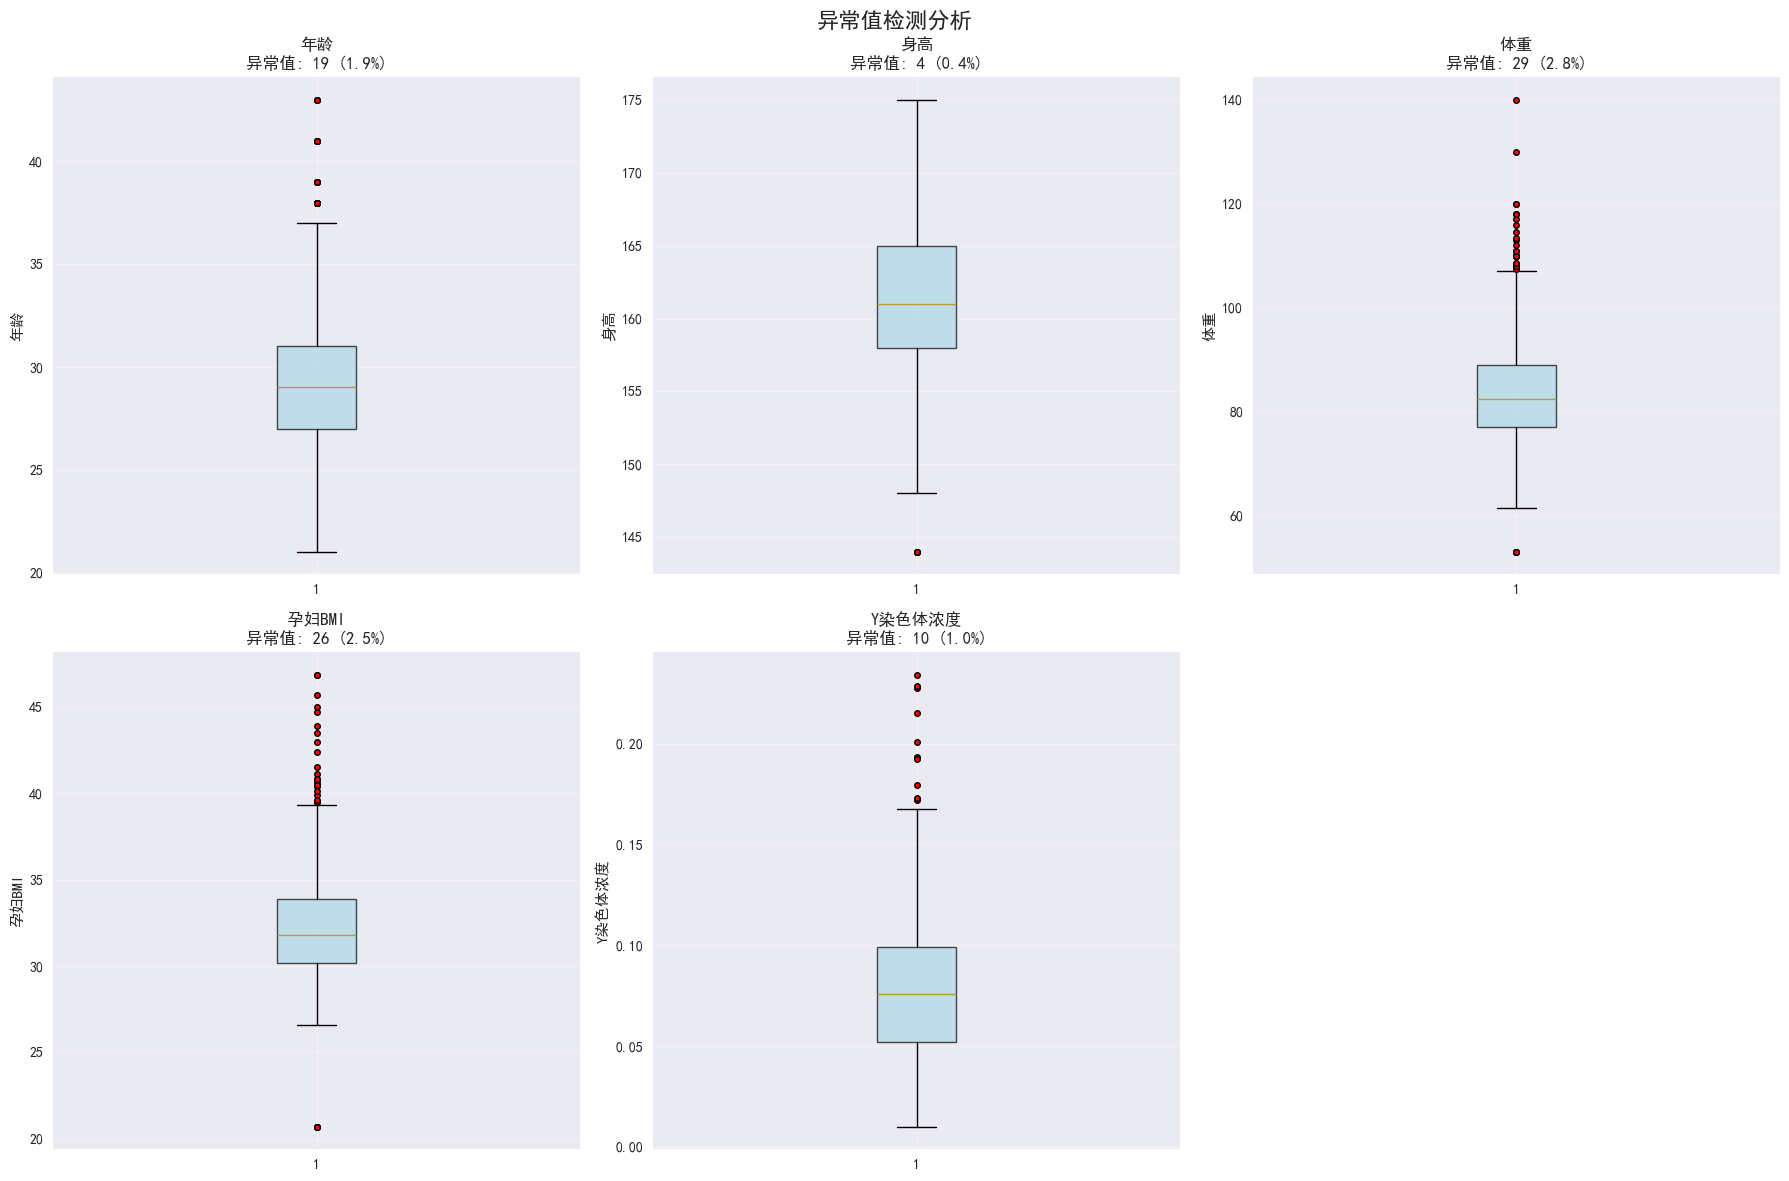

异常值检测结果 (基于IQR方法):
年龄:
  异常值数量: 19
  异常值比例: 1.86%
  正常范围: [21.00, 37.00]

身高:
  异常值数量: 4
  异常值比例: 0.39%
  正常范围: [147.50, 175.50]

体重:
  异常值数量: 29
  异常值比例: 2.84%
  正常范围: [59.00, 107.00]

孕妇BMI:
  异常值数量: 26
  异常值比例: 2.55%
  正常范围: [24.65, 39.39]

Y染色体浓度:
  异常值数量: 10
  异常值比例: 0.98%
  正常范围: [-0.02, 0.17]



In [14]:
# 异常值检测
def outlier_detection(df):
    """检测和分析异常值"""
    
    key_vars = ['年龄', '身高', '体重', '孕妇BMI', 'Y染色体浓度']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('异常值检测分析', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    outlier_summary = {}
    
    for i, var in enumerate(key_vars):
        if i < len(axes):
            data = df[var].dropna()
            
            # 计算IQR
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            
            # 定义异常值边界
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # 找出异常值
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_percentage = (len(outliers) / len(data)) * 100
            
            outlier_summary[var] = {
                'count': len(outliers),
                'percentage': outlier_percentage,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            # 箱线图
            bp = axes[i].boxplot(data, vert=True, patch_artist=True,
                               boxprops=dict(facecolor='lightblue', alpha=0.7),
                               flierprops=dict(marker='o', markerfacecolor='red', markersize=4))
            
            axes[i].set_title(f'{var}\n异常值: {len(outliers)} ({outlier_percentage:.1f}%)')
            axes[i].set_ylabel(var)
            axes[i].grid(True, alpha=0.3)
    
    # 移除多余的子图
    for j in range(len(key_vars), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    # 打印异常值统计
    print("异常值检测结果 (基于IQR方法):")
    print("="*60)
    for var, stats in outlier_summary.items():
        print(f"{var}:")
        print(f"  异常值数量: {stats['count']}")
        print(f"  异常值比例: {stats['percentage']:.2f}%")
        print(f"  正常范围: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")
        print()
    
    return outlier_summary

# 执行异常值检测
outlier_stats = outlier_detection(df_clean)

# 探索性数据分析总结

## 主要发现

### 1. 数据基本信息
- **样本数量**: 1,021个有效Y染色体浓度数据
- **Y染色体浓度范围**: 0.010004 - 0.234218
- **平均值**: 0.078037 ± 0.033378

### 2. 分布特征分析
- **偏度**: 0.693（右偏分布）
- **峰度**: 1.064（比正态分布更尖锐）
- **分布类型**: **Weibull分布**是最佳拟合（p值=0.501）

### 3. 正态性检验结果
所有检验都**拒绝正态分布假设**：
- Shapiro-Wilk: p < 0.001
- Kolmogorov-Smirnov: p = 0.030
- Anderson-Darling: 统计量 > 临界值
- Jarque-Bera: p < 0.001

### 4. 相关性分析
与Y染色体浓度相关性最强的变量（按绝对值排序）：
1. **体重**: 0.177
2. **孕妇BMI**: 0.146  
3. **18号染色体的Z值**: 0.137
4. **身高**: 0.107
5. **年龄**: 0.105

### 5. 建模建议
1. **分布选择**: 考虑使用Weibull分布或Gamma分布
2. **变换方法**: 可以尝试对数变换来改善正态性
3. **特征选择**: 体重和BMI是最重要的预测变量
4. **模型类型**: 考虑广义线性模型(GLM)而非普通线性回归

### 6. 医学意义
- Y染色体浓度显示右偏分布，符合生物医学数据的典型特征
- 母体的生理指标（体重、BMI）对胎儿Y染色体浓度有一定影响
- 其他染色体的Z值与Y染色体浓度相关性较弱